<a href="https://colab.research.google.com/github/titusjscott/multi-layer-perceptron/blob/main/car_sales_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras import backend as K
from keras.metrics import Precision, Recall
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-1-4ef6130068ff>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/titusjscott/multi-layer-perceptron/main/car_purchasing.csv",encoding='ISO-8859-1')

In [3]:
df.describe()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.241674,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.978862,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,40.949969,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.049901,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,51.612263,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


In [4]:
df.shape

(500, 9)

In [5]:
df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [6]:
df.isna().sum()

customer name          0
customer e-mail        0
country                0
gender                 0
age                    0
annual Salary          0
credit card debt       0
net worth              0
car purchase amount    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer name        500 non-null    object 
 1   customer e-mail      500 non-null    object 
 2   country              500 non-null    object 
 3   gender               500 non-null    int64  
 4   age                  500 non-null    float64
 5   annual Salary        500 non-null    float64
 6   credit card debt     500 non-null    float64
 7   net worth            500 non-null    float64
 8   car purchase amount  500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 35.3+ KB


In [8]:
df['country'].value_counts()

Israel                 6
Mauritania             6
Bolivia                6
Greenland              5
Saint Barthélemy       5
                      ..
El Salvador            1
Denmark                1
Oman                   1
Trinidad and Tobago    1
marlal                 1
Name: country, Length: 211, dtype: int64

In [9]:
le = LabelEncoder()
df['country'] = le.fit_transform(df['country'])

scaler = MinMaxScaler(feature_range=(1, 211))
df['country'] = scaler.fit_transform(df[['country']])

In [10]:
df['country'].value_counts()

86.0     6
115.0    6
22.0     6
67.0     5
152.0    5
        ..
52.0     1
47.0     1
138.0    1
188.0    1
210.0    1
Name: country, Length: 211, dtype: int64

In [11]:
a = df[['customer name', 'customer e-mail']]
df = df.drop(a, axis=1)

In [12]:
df.head()

,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,28.0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,18.0,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,2.0,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,42.0,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,27.0,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [13]:
train, test = train_test_split(df, test_size=0.3, random_state=40)
print("Training Data :", train.shape)
print("Testing Data :", test.shape)

Training Data : (350, 7)
Testing Data : (150, 7)


In [14]:
train_df_x = train.iloc[:,:6]
train_df_x = MinMaxScaler().fit_transform(train_df_x)

test_df_x = test.iloc[:,:6]
test_df_x = MinMaxScaler().fit_transform(test_df_x)

print(train_df_x.shape)
print(test_df_x.shape)

(350, 6)
(150, 6)


In [15]:
train_df_y = train.iloc[:,6]

test_df_y = test.iloc[:,6]

print(train_df_y)
print(test_df_y)

154    42369.64247
69     49392.88970
41     41567.47033
444    28645.39425
361    46082.80993
          ...     
440    41147.46679
165    40879.19107
7      47434.98265
219    41673.44617
326    36543.93642
Name: car purchase amount, Length: 350, dtype: float64
167    35438.80549
169    38182.30465
461    38243.06228
253    37093.92033
42     28031.20985
          ...     
275    38705.65839
420    62028.71192
23     46635.49432
58     38147.81018
274    52116.90791
Name: car purchase amount, Length: 150, dtype: float64


In [16]:
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = tf.keras.Sequential()
model.add(Dense(units=25, activation='relu', input_dim=6, bias_initializer = 'random_normal'))
model.add(Dense(units=5, activation='relu', bias_initializer = 'random_normal'))
model.add(Dense(units=1, activation='linear', bias_initializer = 'random_normal'))

model.compile(optimizer='adam', loss='mean_squared_error',metrics=[MeanAbsoluteError(), RootMeanSquaredError(), r_squared] )

model.fit(train_df_x, train_df_y, batch_size=5, epochs=500)

metrics = model.evaluate(test_df_x, test_df_y)
print("Mean Absolute Error:", metrics[1])
print("Root Mean Squared Error:", metrics[2])
print("R-squared:", metrics[3])

Epoch 1/500
70/70 [==============================] - 1s 2ms/step - loss: 2058664192.0000 - mean_absolute_error: 44160.7031 - root_mean_squared_error: 45372.5039 - r_squared: -51.4195
Epoch 2/500
70/70 [==============================] - 0s 2ms/step - loss: 2058431232.0000 - mean_absolute_error: 44158.1250 - root_mean_squared_error: 45369.9375 - r_squared: -49.6063
Epoch 3/500
70/70 [==============================] - 0s 2ms/step - loss: 2057757056.0000 - mean_absolute_error: 44150.6211 - root_mean_squared_error: 45362.5078 - r_squared: -57.5384
Epoch 4/500
70/70 [==============================] - 0s 3ms/step - loss: 2056299136.0000 - mean_absolute_error: 44134.3867 - root_mean_squared_error: 45346.4336 - r_squared: -44.4055
Epoch 5/500
70/70 [==============================] - 0s 4ms/step - loss: 2053726848.0000 - mean_absolute_error: 44105.7930 - root_mean_squared_error: 45318.0625 - r_squared: -43.3034
Epoch 6/500
70/70 [==============================] - 0s 2ms/step - loss: 2049788544.0

In [17]:
y_pred = model.predict(test_df_x)

mse = mean_squared_error(test_df_y, y_pred)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(test_df_y, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(test_df_y, y_pred)
print("R-squared:", r2)

5/5 [==============================] - 0s 2ms/step
Mean Squared Error: 17158598.432752166
Root Mean Squared Error: 4142.293861226189
Mean Absolute Error: 3705.951340164583
R-squared: 0.8709101367631759


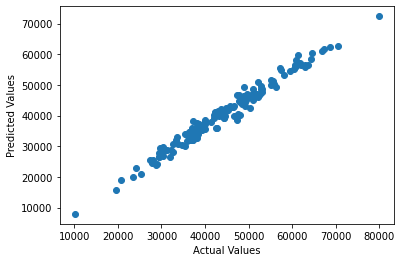

In [18]:
plt.scatter(test_df_y, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [20]:
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

def build_model():
    model = tf.keras.Sequential()
    model.add(Dense(units=25, activation='relu', input_dim=6, bias_initializer='random_normal'))
    model.add(Dense(units=5, activation='relu', bias_initializer='random_normal'))
    model.add(Dense(units=1, activation='linear', bias_initializer='random_normal'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError(),
                                                                          tf.keras.metrics.RootMeanSquaredError(),
                                                                          r_squared])
    return model

model = KerasRegressor(build_fn=build_model, batch_size=5, epochs=500)


# fit the model on training data
model.fit(train_df_x, train_df_y)

# evaluate model using cross-validation
cv_results = cross_val_score(model, df_x, df_y, cv=10, scoring='neg_mean_squared_error')
print("Cross Validation Results:", np.mean(np.abs(cv_results)))

# evaluate model on test data
y_pred = model.predict(test_df_x)
mse = mean_squared_error(test_df_y, y_pred)
mae = mean_absolute_error(test_df_y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test_df_y, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Streaming output truncated to the last 5000 lines.
90/90 [==============================] - 0s 3ms/step - loss: 47992708.0000 - mean_absolute_error: 5639.9370 - root_mean_squared_error: 6927.6768 - r_squared: 0.1436
Epoch 7/500
90/90 [==============================] - 0s 2ms/step - loss: 46949448.0000 - mean_absolute_error: 5527.6343 - root_mean_squared_error: 6851.9668 - r_squared: 0.1035
Epoch 8/500
90/90 [==============================] - 0s 2ms/step - loss: 47068752.0000 - mean_absolute_error: 5549.5112 - root_mean_squared_error: 6860.6670 - r_squared: 0.2426
Epoch 9/500
90/90 [==============================] - 0s 3ms/step - loss: 48445876.0000 - mean_absolute_error: 5649.9082 - root_mean_squared_error: 6960.3071 - r_squared: -0.2087
Epoch 10/500
90/90 [==============================] - 0s 3ms/step - loss: 47478056.0000 - mean_absolute_error: 5557.8101 - root_mean_squared_error: 6890.4321 - r_squared: 0.2151
Epoch 11/500
90/90 [==============================] - 0s 2ms/step - loss: 